# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the main functions in the Spitzer-ulens package.

In [360]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool

from Spitzer_ulens import data_config
from Spitzer_ulens.MuLensEvent import MuLensEvent
from Spitzer_ulens import models
from Spitzer_ulens import PLD
from Spitzer_ulens import plot
from Spitzer_ulens import mcmc

## Defining Variables
These can be modified for use with different events and different models.

In [2]:
EVENT_NAME = 'ob171140'
TELESCOPE = 'spitzer'
EVENT_COORDS = ('17:47:31.93','-24:31:21.6')
#MODELFUNC = models.single_lens
MODELFUNC = models.binary_lens_all

## Configuration and Preparation

In [3]:
load_pkl_from_file = True
load_centroid_from_file = True
save_event = True

if load_pkl_from_file and load_centroid_from_file:
    # Load event object from pre-existing pickle file
    filename = 'data/'+EVENT_NAME+'/PLD_input/'+EVENT_NAME+'_'+TELESCOPE+'.pkl'
    with open(filename, 'rb') as input:
        event = pickle.load(input)
else:
    if load_centroid_from_file:
        # Load centroid data from pre-existing centroid.out file
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.load_centroid_data(EVENT_NAME,TELESCOPE)
    else:
        # All data should be downloaded into src_dir directory
        src_dir = 'data'
        # Configure directory structure for use with data_config functions
        data_config.directory_config(EVENT_NAME,TELESCOPE,src_dir)
        # Retrieve raw centroid data
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.get_centroid_data(EVENT_NAME,TELESCOPE,EVENT_COORDS,timerange=(0,8000))
    # Obtain centroid pixel coordinates
    XCENT,YCENT = data_config.target_central_px(XDATA,YDATA)
    # Obtain 5-by-5 images and image errors
    IMG,IMG_E = data_config.target_image_square(EVENT_NAME,XCENT,YCENT,CBCD,CBUNC)
    # Create and save event object
    event = MuLensEvent(EVENT_NAME,TELESCOPE,AOR,TIMES,XDATA,YDATA,IMG,IMG_E)
    event.save()

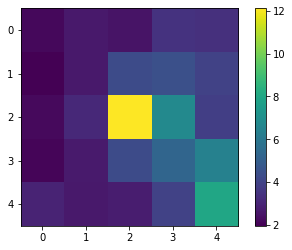

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(event.IMG[1][40])
fig.colorbar(im)
plt.show()

## Least-Squares Fit

Text(0, 0.5, 'Flux (MJy/sr)')

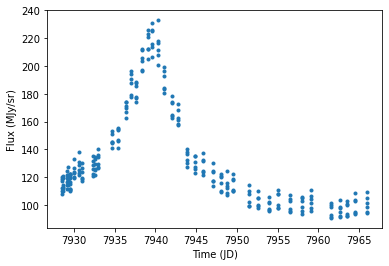

In [5]:
# Get raw photometry, error, and binned error
PTOT,PTOT_E,E_BIN = event.aperture_photometry()
# Flatten in chronological order for plotting purposes
time,ptot = event.chrono_flatten(PTOT)
# Plot our raw data so that we can make some parameter estimates.
plt.plot(time,ptot,'.')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (MJy/sr)')

In [6]:
# Make an initial guess for model parameters, which will be used as starting point for LM fit

# Single lens model:
#fb,t0,fs,tE = 84.86,7940.195,19.707,14.58
#p0 = np.array([fb,t0,fs,tE]) #for single lens: fb, t0, fs, tE
#bounds = ([0,7935,0,0],[140,7945,np.inf,np.inf])

# Binary lens model:
s     = 0.815       # separation between the two lenses (in Einstein radius of total mass)
q     = 0.0099      # mass ratio: Right-lens' mass divided by left-lens' mass
rho   = 1e-6        # source radius in Einstein radii of the total mass.
alpha = np.pi-2.561 # angle between lens axis and source trajectory (rad) VBBL_alpha = PI-OSU_alpha
tE    = 14.58       # einstein radius crossing time
t0    = 7940.195    # time of peak magnification
u0    = 0.1343      # impact parameter
fb    = 76          # baseline flux
fs    = 21          # source flux
p0 = np.asarray([s, q, rho, alpha, tE, t0, u0, fb, fs])
# Estimate some bounds on these parameters. These do not have to be tight constraints.
bounds = ([0,0,0,-np.inf,0,7920,-np.inf,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,7960,np.inf,np.inf,np.inf])

In [7]:
#PTOT,PTOT_E,E_BIN = event.aperture_photometry()
#PTOT_AV = np.median(PTOT,axis=0)
#DC_PERTIME = PTOT - PTOT_AV
#DC_PERDITHER = DC_PERTIME.mean(axis=1)
#print(DC_PERDITHER)
#PTOT = (PTOT.T-DC_PERDITHER).T

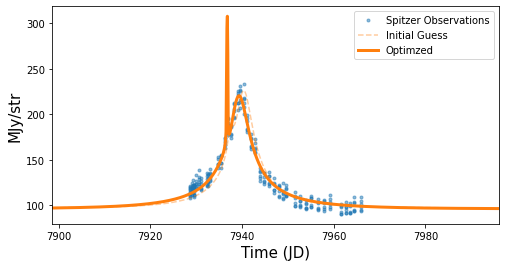

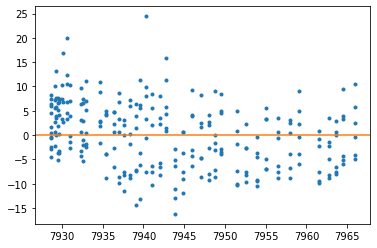

In [8]:
# Obtain raw photometry and errors
PTOT,PTOT_E,E_BIN = event.aperture_photometry()
# Perform LM fit and plot resulting curve
popt,perr,bestfit,resi_pre,timeplot,lcoptim = event.modelfit(MODELFUNC,p0,PTOT,makeplots=True,bounds=bounds)
plt.figure()
plt.plot(event.chrono_flatten()[0],resi_pre,'.')
plt.axhline(color='C1')

## Solving PLD Coefficients Analytically

RMS before  :  6.61862912869253
RMS after  :  0.9811180084653887


(<Figure size 576x648 with 3 Axes>,
 array([<AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:xlabel='Time (JD)', ylabel='Residuals (MJy/str)'>],
       dtype=object))

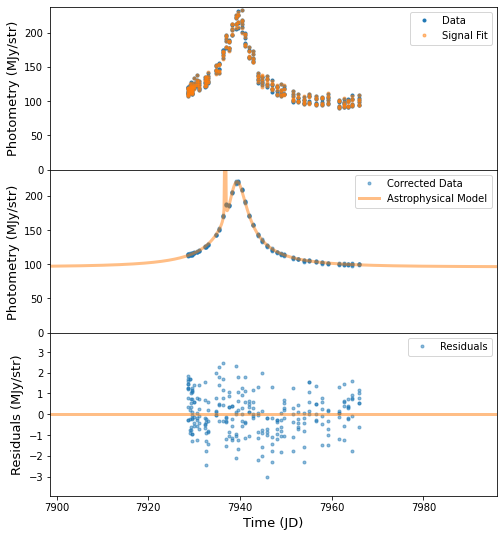

In [9]:
# Get fractional flux
PNORM = event.get_PNORM()
# Solve for PLD coefficients analytically
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, popt, MODELFUNC)
# Get detector model and divide it out to get new best-fit
FIT, SYS, CORR, RESI = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,ptot,ptot_e,corr,resi,fit,sys = event.chrono_flatten(PTOT,PTOT_E,CORR,RESI,FIT,SYS)
# Compute RMS error before and after
RMS_before, RMS_after = PLD.get_RMS(resi_pre,label='RMS before',visual=True), PLD.get_RMS(resi,label='RMS after',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit, corr, resi, timeplot, lcoptim)

# MCMC Fit for PLD Parameters

In [296]:
load_chain_from_file = True

if load_chain_from_file:
    # Load chains from files
    path = os.path.join('data',EVENT_NAME,'mega_MCMC')
    chain = np.load(path+'/samplerchain.npy')
    lnprob = np.load(path+'/samplerlnpro.npy')
    posit = np.load(path+'/samplerposit.npy')
    PLD_chain = np.load(path+'/PLD_chain.npy')
else:
    # Create wrapper object for PLD coefficient chain to make it mutable 
    PLD_chain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
    # generate the MCMC sampler
    sampler = mcmc.get_MCMC_sampler(popt,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    # Initialize the initial parameter positions for each walker by adding a random offset
    pos0 = [popt*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    # Run the MCMC
    chain,posit,lnprob = mcmc.run_MCMC(sampler,pos0)
    # Retrieve PLD coefficient chain from the wrapper object
    PLD_chain = PLD_chain.chain
    # Save chains to files
    #mcmc.save_chain(EVENT_NAME,chain,posit,lnprob,PLD_chain)

In [291]:
lnprob_av = np.mean(lnprob)
popt_mcmc = np.mean(chain,axis=(0,1))
print(popt_mcmc.shape)

(9,)


RMS after MCMC  :  0.6893780883159933


(<Figure size 576x648 with 3 Axes>,
 array([<AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:ylabel='Photometry (MJy/str)'>,
        <AxesSubplot:xlabel='Time (JD)', ylabel='Residuals (MJy/str)'>],
       dtype=object))

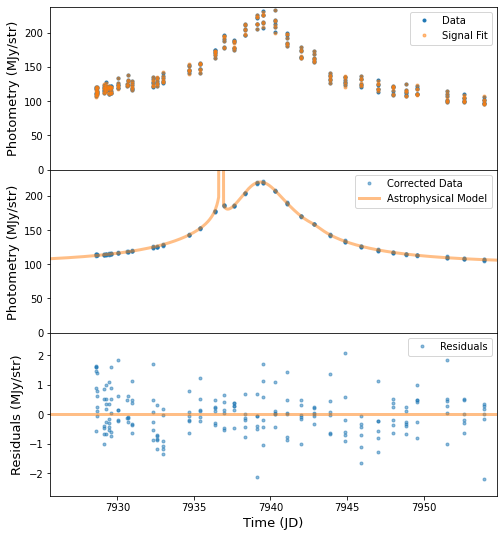

In [294]:
# Optimal parameters are the average position of the walkers
#popt_mcmc = np.mean(posit,axis=0)
# Solve for PLD coefficients analytically
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, popt_mcmc, MODELFUNC)
# Get detector model and divide it out to get new best-fit
FIT_MCMC, SYS_MCMC, CORR_MCMC, RESI_MCMC = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,corr_mcmc,resi_mcmc,fit_mcmc,sys_mcmc = event.chrono_flatten(CORR_MCMC,RESI_MCMC,FIT_MCMC,SYS_MCMC)
# Compute RMS error before and after
RMS_mcmc = PLD.get_RMS(resi_mcmc,label='RMS after MCMC',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit_mcmc, corr_mcmc, resi_mcmc, timeplot, MODELFUNC(timeplot,*popt_mcmc))

# Error Analysis

In [434]:
# Marginalize
posit = chain.reshape(-1,len(p0))

# Get the percentile
percs = np.percentile(posit, [16, 50, 84],axis=0)
(MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*percs))))

popt_mcmc = MCMC_Results[:,0]
std_hi = MCMC_Results[:,1]
std_lo = MCMC_Results[:,2]

# Get most probable params
probs = lnprob.flatten()
p_max = posit[np.argmax(probs)]

print(popt_mcmc)
print(p_max)
print(MCMC_Results)

[9.15803357e-01 2.49649034e-02 1.26803104e-03 7.23380010e-01
 1.29490973e+01 7.93894131e+03 1.49616589e-01 7.63964079e+01
 2.42861742e+01]
[9.15890893e-01 2.67691263e-02 1.63476051e-03 7.25883804e-01
 1.26954677e+01 7.93892510e+03 1.52078753e-01 7.61243062e+01
 2.47946032e+01]
[[9.15803357e-01 4.95973081e-03 4.73966960e-03]
 [2.49649034e-02 2.68875386e-03 7.00572222e-03]
 [1.26803104e-03 1.42062295e-03 8.67234352e-04]
 [7.23380010e-01 4.54683538e-03 4.76142839e-03]
 [1.29490973e+01 1.09520744e+00 3.12976933e-01]
 [7.93894131e+03 5.96298642e-02 2.36836100e-02]
 [1.49616589e-01 2.82531631e-03 6.92456772e-03]
 [7.63964079e+01 1.39858927e+00 8.53355974e-01]
 [2.42861742e+01 6.66381719e-01 1.98631664e+00]]


# Extra Plots

(100000, 9)


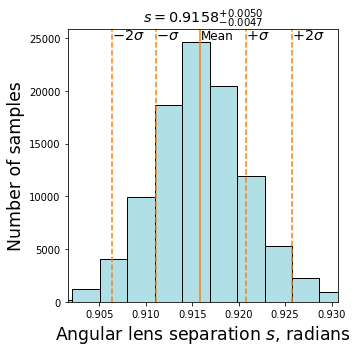

In [480]:
print(posit.shape)
nbins=20
i = 0

pmin = posit.min(axis=0)
pmax = posit.max(axis=0)
bins = np.linspace(pmin,pmax,nbins)
aa,bb = np.histogram(posit[:,i],bins[:,i])
cents = 0.5*(bb[1:]+bb[:-1])

fig,ax = plt.subplots(figsize=(5,5))
ax.bar(cents,aa,width=bb[1]-bb[0],color='powderblue',edgecolor='black')

ax.axvline(popt_mcmc[i],color='C1',label='Mean')
ax.axvline(popt_mcmc[i]-std_lo[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]+std_hi[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]-2*std_lo[i],color='C1',ls='--')
ax.axvline(popt_mcmc[i]+2*std_hi[i],color='C1',ls='--')
ax.text(popt_mcmc[i]+0.0001,24850,'Mean',size='large')
ax.text(popt_mcmc[i]-std_lo[i],24900,r'$-\sigma$',size='x-large')
ax.text(popt_mcmc[i]+std_hi[i],24900,r'$+\sigma$',size='x-large')
ax.text(popt_mcmc[i]-2*std_lo[i],24900,r'$-2\sigma$',size='x-large')
ax.text(popt_mcmc[i]+2*std_hi[i],24900,r'$+2\sigma$',size='x-large')
#ax.set_xticks(bb)
ax.set_xlabel(r'Angular lens separation $s$, radians',size='xx-large')
ax.set_ylabel('Number of samples',size='xx-large')
ax.set_title(r'$s = %.4f_{-%.4f}^{+%.4f}$' % (popt_mcmc[i],std_lo[i],std_hi[i]),size='x-large')
ax.set_xlim(popt_mcmc[i]-3*std_lo[i],popt_mcmc[i]+3*std_hi[i])
plt.tight_layout()
plt.savefig('errors.png',dpi=300)

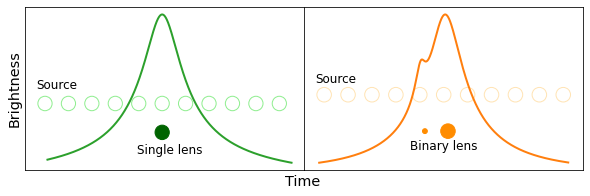

In [500]:
s, q, rho, alpha, tE, t0, u0, fb, fs = p0
p0_single = np.array([9.20263259e+01, 7.93931983e+03, 1.19630450e+02, 7.66795064e+00])
fb_s,t0_s,fs_s,tE_s = p0_single
timeplot = np.linspace(t0-tE,t0+tE,1000)
fig,ax = plt.subplots(1,2,figsize=(10,3))

y1 = models.single_lens(timeplot,*p0_single)
y2 = MODELFUNC(timeplot,*p0)

w1 = 1.7
h1 = 10

w2 = 1.7
h2 = 12

ylens1 = 130
ylens2 = 130

ax[0].add_patch(patches.Ellipse((t0_s,ylens1),w1,h1,color='darkgreen'))
ax[0].text(t0_s-3,ylens1-15,'Single lens',size='large')
ax[0].text(t0_s-15,ylens1+30,'Source',size='large')
source_ts = np.linspace(t0_s-14,t0_s+14,11)
for t in source_ts:
    ax[0].add_patch(patches.Ellipse((t,ylens1+20),w1,h1,color='lightgreen',fill=False))
    
ax[1].add_patch(patches.Ellipse((t0+0.5,ylens2),w2,h2,color='darkorange'))
ax[1].add_patch(patches.Ellipse((t0-2.2,ylens2),w2/3,h2/3,color='darkorange'))
ax[1].text(t0-4,ylens2-15,'Binary lens',size='large')
ax[1].text(t0-15,ylens2+40,'Source',size='large')
source_ts = np.linspace(t0-14,t0+14,11)
for t in source_ts:
    ax[1].add_patch(patches.Ellipse((t,ylens2+30),w2,h2,color='moccasin',fill=False))

ax[0].plot(timeplot,y1,color='C2',lw=2,label='Single-lens light curve')
ax[1].plot(timeplot,y2,color='C1',lw=2,label='Binary-lens light curve')
ax[0].xaxis.set_visible(False)
#ax[0].yaxis.set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
#ax[0].legend(fontsize=14,loc=8)
#ax[1].legend(fontsize=14,loc=8)
ax[0].yaxis.set_ticks([])
ax[0].set_ylabel('Brightness',size='x-large')
ax[0].text(7954,93,'Time',size='x-large')

if False:
    ax[0].axvline(x=t0_s,ls='--',color='lightgreen')
    ax[0].text(t0_s,110,r'$t_0$',fontsize=16)
    ax[0].plot([t0_s,t0_s+tE_s],[models.single_lens(t0_s-tE_s,*p0_single),models.single_lens(t0_s+tE_s,*p0_single)],color='lightgreen',ls='--')
    ax[0].text(t0_s+1,130,r'$t_E$',fontsize=16)

    ax[1].axvline(x=t0,ls='--',color='moccasin')
    ax[1].text(t0,110,r'$t_0$',fontsize=16)
    ax[1].plot([t0,t0+tE],[MODELFUNC([t0-tE],*p0),MODELFUNC([t0+tE],*p0)],color='moccasin',ls='--')
    ax[1].text(t0+1,130,r'$t_E$',fontsize=16)

#fig.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('comparemodels.png',dpi=300)

In [120]:
dudchain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
lnlike = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)

bic = popt_mcmc.size*np.log(ptot.size)-lnlike

1229.4420090840272


0.6054688808212013


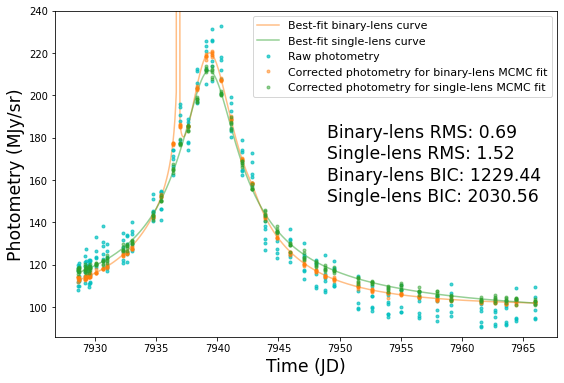

In [482]:
timeplot = np.linspace(time[0],time[-1],1000)

corr_single = np.loadtxt('single_corr.txt')
popt_single = np.loadtxt('single_pars.txt')

print(bic/2030.5618472356946)

fig,ax = plt.subplots(figsize=(9,6))
ax.plot(timeplot,MODELFUNC(timeplot,*popt_mcmc),color='C1',alpha=0.5,label='Best-fit binary-lens curve')
ax.plot(timeplot,models.single_lens(timeplot,*popt_single),color='C2',alpha=0.5,label='Best-fit single-lens curve')
ax.plot(time,ptot,'.',color='c',alpha=0.7,label='Raw photometry')
ax.plot(time,corr_mcmc,'.',color='C1',alpha=0.5,label='Corrected photometry for binary-lens MCMC fit')
ax.plot(time,corr_single,'.',color='C2',alpha=0.5,label='Corrected photometry for single-lens MCMC fit')
ax.set_ylim(fb+10,240)
ax.legend(fontsize=11)
ax.set_xlabel('Time (JD)',size='xx-large')
ax.set_ylabel('Photometry (MJy/sr)',size='xx-large')
ax.text(7949,180,'Binary-lens RMS: %.2f'%0.6893780883159933,fontsize='xx-large')
ax.text(7949,170,'Single-lens RMS: %.2f'%1.5189632473783468,fontsize='xx-large')
ax.text(7949,160,'Binary-lens BIC: %.2f'%bic,fontsize='xx-large')
ax.text(7949,150,'Single-lens BIC: %.2f'%2030.5618472356946,fontsize='xx-large')
plt.savefig('double_single_MCMC_fits.png',dpi=400)

Text(0, 0.5, 'Residuals (MJy/sr)')

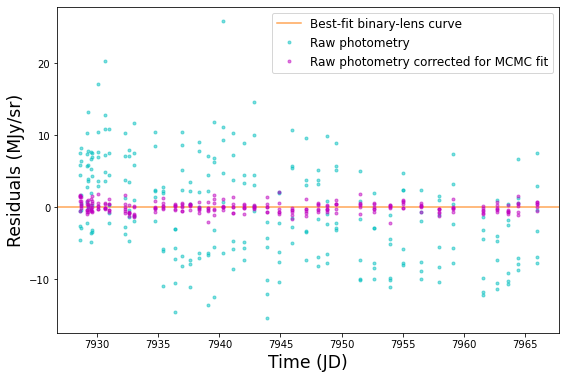

In [190]:
timeplot = np.linspace(time[0],time[-1],1000)
bf = MODELFUNC(time,*popt_mcmc)
fig,ax = plt.subplots(figsize=(9,6))
ax.axhline(color='C1',alpha=0.7,label='Best-fit binary-lens curve')
ax.plot(time,ptot-bf,'.',color='c',alpha=0.5,label='Raw photometry')
#ax.plot(time,corr-bf,'.',color='y',alpha=0.5,label='Raw photometry corrected for LM fit')
ax.plot(time,corr_mcmc-bf,'.',color='m',alpha=0.5,label='Raw photometry corrected for MCMC fit')
ax.legend(fontsize='large')
ax.set_xlabel('Time (JD)',size='xx-large')
ax.set_ylabel('Residuals (MJy/sr)',size='xx-large')

1229.4420090840272
0.9811180084653295


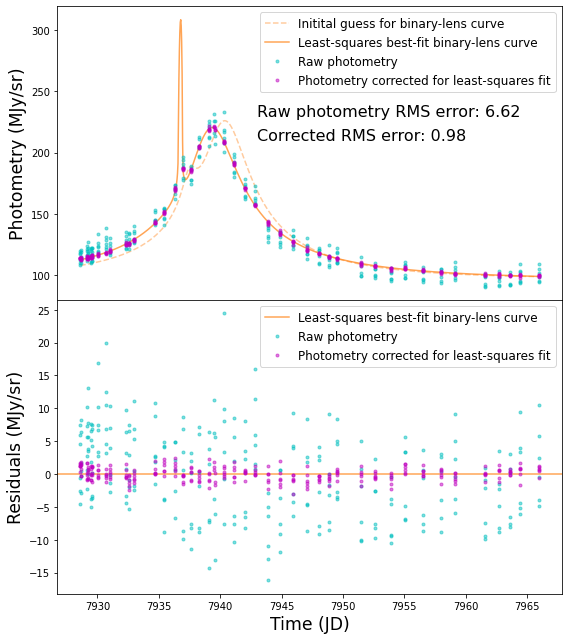

In [252]:
lnlike_lm = mcmc.lnlike(popt, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
bic_lm = popt.size*np.log(ptot.size)-lnlike
rms_corr = PLD.get_RMS(corr-bf)
rms_pre = PLD.get_RMS(resi_pre)
print(bic_lm)
print(rms_lm)

timeplot = np.linspace(time[0],time[-1],1000)
bf = MODELFUNC(time,*popt)
fig,ax = plt.subplots(2,figsize=(8,9))

ax[0].plot(timeplot,MODELFUNC(timeplot,*p0),color='C1',alpha=0.4,label='Initital guess for binary-lens curve',ls='--')
ax[0].plot(timeplot,MODELFUNC(timeplot,*popt),color='C1',alpha=0.7,label='Least-squares best-fit binary-lens curve')
ax[0].plot(time,ptot,'.',color='c',alpha=0.5,label='Raw photometry')
ax[0].plot(time,corr,'.',color='m',alpha=0.5,label='Photometry corrected for least-squares fit')
ax[0].legend(fontsize='large')
ax[0].set_ylabel('Photometry (MJy/sr)',size='xx-large')
ax[0].xaxis.set_visible(False)

ax[0].text(7943,230,'Raw photometry RMS error: %.2f'%rms_pre,size=16)
ax[0].text(7943,210,'Corrected RMS error: %.2f'%rms_corr,size=16)

ax[1].axhline(color='C1',alpha=0.7,label='Least-squares best-fit binary-lens curve')
ax[1].plot(time,ptot-bf,'.',color='c',alpha=0.5,label='Raw photometry')
ax[1].plot(time,corr-bf,'.',color='m',alpha=0.5,label='Photometry corrected for least-squares fit')
ax[1].legend(fontsize='large')
ax[1].set_xlabel('Time (JD)',size='xx-large')
ax[1].set_ylabel('Residuals (MJy/sr)',size='xx-large')

fig.tight_layout()
plt.subplots_adjust(hspace=0)

plt.savefig('lsq_fit.png')

In [18]:
print(lnprob.shape)
print(np.mean(lnprob))

(100, 1000)
-1187.6400270298836


(258,)


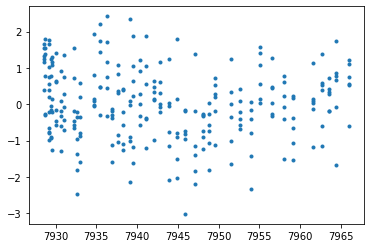

In [272]:
_,fit = event.chrono_flatten(FIT)
print(fit.shape)
plt.plot(time,ptot-fit,'.')
#plt.plot(time,ptot,'.')

In [20]:
dudchain = mcmc.PLDCoeffsChain(np.empty(np.size(X)))
bic = mcmc.lnlike(popt_mcmc, MODELFUNC, event.TIMES, PTOT, PTOT_E, E_BIN, PNORM, dudchain)
print(bic)

-1179.4653728197327


In [160]:
np.shape(PTOT/CORR_MCMC)
print((PTOT/CORR_MCMC)[0])

[0.9822774  0.99166721 1.02881724 1.0227292  1.02086361 0.99828026
 1.0328703  1.03171201 0.99564506 0.97780493 0.98678607 0.99087418
 1.01503504 0.96173453 0.9564272  0.96287894 0.95508963 0.97216539
 0.97107934 0.98057503 1.12445438 0.96666125 0.97684272 1.00096689
 0.93275595 0.95853302 1.00086255 0.97288294 0.98864501 0.94174565
 0.97659472 0.92921828 0.92329838 0.90868049 0.9460047  0.92701661
 0.94906952 0.93543684 0.90325599 0.8991296  0.91900499 0.93336311
 0.92865368]


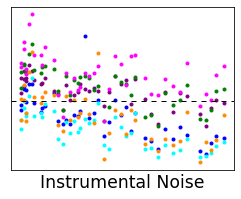

In [429]:
D = PTOT/CORR_MCMC
fig,ax = plt.subplots(figsize=(4,3))
colors=['blue','purple','green','cyan','magenta','darkorange']
for i in range(len(PTOT)):
    ax.plot(event.TIMES[i],D[i],'.',color=colors[i])
#ax.set_xlabel('Time (JD)',size='x-large')
#ax.set_ylabel('Instrumental Noise',size='x-large')
ax.axhline(y=1,color='black',lw=1,ls=(0,(5,5)))
ax.xaxis.set_ticks([])
ax.set_xlabel('Instrumental Noise',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('instrumental_noise.png')

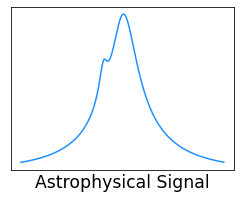

In [174]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(timeplot,MODELFUNC(timeplot,*p0),color='dodgerblue')
#plt.xlabel('Time (JD)',size='x-large')
#plt.ylabel('Photometry',size='x-large')
ax.xaxis.set_ticks([])
ax.set_xlabel('Astrophysical Signal',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('astrophysical_model.png')

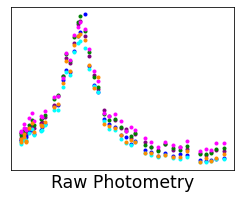

In [176]:
fig,ax = plt.subplots(figsize=(4,3))
for i in range(len(PTOT)):
    ax.plot(event.TIMES[i],PTOT[i],'.',color=colors[i])
#plt.xlabel('Time (JD)',size='x-large')
#plt.ylabel('Photometry',size='x-large')
ax.xaxis.set_ticks([])
ax.set_xlabel('Raw Photometry',size='xx-large')
ax.yaxis.set_visible(False)
plt.savefig('raw_photometry.png')